In [474]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import seaborn as sns 
from pept import PointData
from scipy.interpolate import interp1d
from sklearn.neighbors import KernelDensity
import pandas as pd
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
%matplotlib widget

In [475]:
def loadTruePath(path: str) -> PointData:
    data = np.loadtxt(path, skiprows = 3)
    points = np.array([data[:, 0], data[:, 5], data[:, 6], data[:, 7]]).T
    pData = PointData(points)
    return pData

In [512]:
trackedPath = PointData(np.load("/home/rayhaan/randomWalk_V3/GATE_Generation/Sigma_2.0mm_Varying_Tau_0.08_1.20ms/Tracks/RW3_TS_1.00ms_SS_2.00mm.npy"))
truePath = loadTruePath(path = "/home/rayhaan/randomWalk_V3/GATE_Generation/Sigma_2.0mm_Varying_Tau_0.08_1.20ms/Placements/RW3_TS_1.00ms_SS_2.00mm.placements")

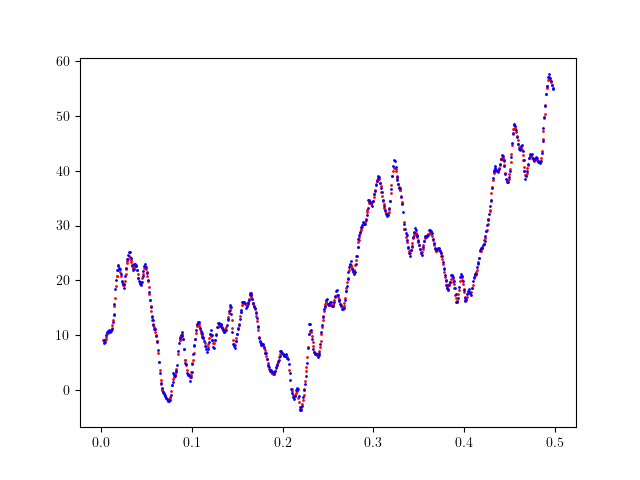

In [513]:
plt.close("all")
fig, ax = plt.subplots(1, 1)
ax.scatter(trackedPath['t'], trackedPath['x'], color = 'r', s = 1)
ax.scatter(truePath['t'], truePath['x'], color = 'b', s  =1)


In [514]:
def errorCalculation(truePath: PointData, trackedPath: PointData) -> np.float64:
    fx = interp1d(trackedPath['t'], trackedPath['x'], fill_value = "extrapolate", kind = "slinear")
    xInterp = fx(truePath['t'])
    residX = xInterp - truePath['x']
    return np.abs(residX)

In [515]:
xResid = errorCalculation(truePath = truePath, trackedPath = trackedPath)

In [516]:
len(xResid)

497

In [517]:
xResid = xResid[~np.isnan(xResid)]

In [518]:
steps = np.array([(truePath['x'][i+1] - truePath['x'][i]) for i in range(len(truePath['x']) - 1)], dtype = np.float32)[:-1]
xResid = xResid[:-2]

In [519]:
stepResid = np.array([np.abs(steps), xResid]).T

In [520]:
orderedStepResid = stepResid[stepResid[:, 0].argsort()]

In [521]:
splitOrderedStepResid = np.array_split(orderedStepResid, 10)

In [522]:
def performKde(splits, xvals):
    allDensity = []
    for i in range(len(splits)):
        kde = KernelDensity(kernel = "gaussian", bandwidth = 0.15).fit(splits[i][:, 1].reshape(-1, 1))
        logDensity = kde.score_samples(xvals.reshape(-1, 1))
        density = np.exp(logDensity)
        allDensity.append(density)
    return allDensity

In [523]:
xValues = np.linspace(-2.5, 2.5, 1000)
GKDEall = performKde(splitOrderedStepResid, xValues)

In [524]:
def computeMean_dx(splits):
    means = []
    for i in range(len(splits)):
        mean = np.mean(splits[i][:, 0])
        means.append(mean)
    return np.array(means, dtype = np.float32)

In [525]:
means = computeMean_dx(splits = splitOrderedStepResid)

In [526]:
means = np.array(["{:.2f}".format(float(means[i])) for i in range(len(means))])

In [527]:
allDat = np.array([means, GKDEall], dtype = "object")

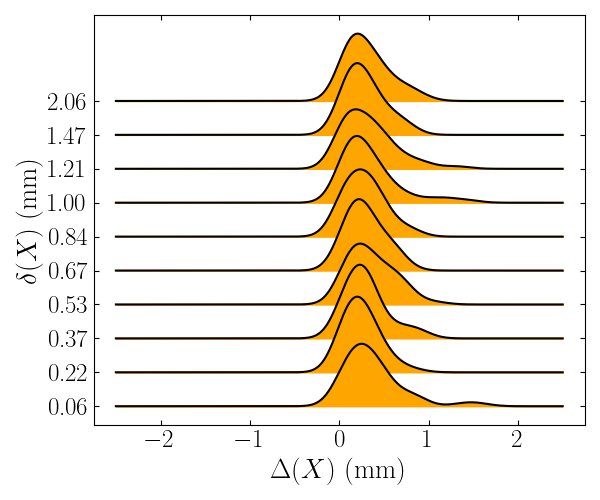

In [528]:
plt.close("all")
fig, ax = plt.subplots(1, 1, figsize = (6, 5))
s = 20

shiftVal = 0.8
xx = np.linspace(-2.5, 2.5, 1000)
shift = 0
yVals = []
for i in range(len(means)):
    ax.plot(xValues, GKDEall[i] + shift, color = 'k', lw = 1.5)
    ax.fill_between(x = xValues, y1 = GKDEall[i] + shift, y2 = np.repeat(shift, len(xValues)), color = "orange", alpha = 1.0)
    yVals.append(shift)
    shift += shiftVal

ax.get_xaxis().set_tick_params(direction = "in", which = "both", top = True)
ax.get_yaxis().set_tick_params(direction = "in", which = "both", right = True)

ax.tick_params(axis="x", labelsize = s - 2) 
ax.tick_params(axis="y", labelsize = s - 2)

ax.set_yticks(yVals, means)

ax.set_xlabel(r"$\Delta(X)$ (mm)", fontsize = s)
ax.set_ylabel(r"$\delta(X)$ (mm)", fontsize = s)

fig.tight_layout()



In [529]:
np.save("/home/rayhaan/randomWalk_V3/Data/ridgeDataEdgeCases/Lambda_2.00mm_Tau_1.0ms", arr = allDat)